In [12]:
import numpy as np
import os
import scipy.io as scio
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
import matplotlib as mpl
from matplotlib import pyplot as plt
from tqdm import tqdm
from tqdm.auto import trange
from matplotlib import colors
import argparse
import sys
sys.path.append("/media/miplab-nas2/Data3/Danyang/Multi-Echo-BOLD_fingerprinting")
sys.path.append("E:\sp2\Multi-Echo-BOLD_fingerprinting")
from scipy.io import loadmat

from fingerprinting.load_data import load_data_split
from fingerprinting.pca_denoising import pca_denoising
from fingerprinting.draw_results import *
from fingerprinting.ICC import calculate_ICC
from fingerprinting.utils import *
from fingerprinting.utils_identifiability import *
from fingerprinting.utils_neuromaps_brain import *

In [13]:
data_path='./data0'
result_path='./fingerprinting/results_speedup_test'
subjects_num=-1
if_icc=False
if_save_FC=False

echoes_total_num = 5  # including optimal combination
echo_optcomb = echoes_total_num - 1 # the last echo is the optcomb
subjects_total_num = int(len(os.listdir(data_path)) / (echoes_total_num)) # there is another optimal TS.
if subjects_num == -1:
    subjects_num = subjects_total_num
print("There are " + str(subjects_total_num) + " subjects with " + str(echoes_total_num) + " echoes (include 1 optcomb).")

# Load data
TCs_test, TCs_retest, FCs_test, FCs_retest, orig_matrixs_test, orig_matrixs_retest = load_data_split(data_path, subjects_num, echoes_total_num)
TCs = np.concatenate((TCs_test, TCs_retest), axis=3)

There are 84 subjects with 5 echoes (include 1 optcomb).


In [3]:
# for echo_test in tqdm(range(echoes_total_num), desc='echo1', leave=False): # Another echo_index: for optimal combination.
#     for echo_retest in tqdm(range(echoes_total_num), desc='echo2', leave=False):
ICC_matrices = []
ICC_matrices_opt = []
for echo_test in tqdm(range(echoes_total_num), desc='echo1', leave=False):
    echo_retest = echo_test
    FC_list_test = orig_matrixs_test[echo_test].T
    FC_list_retest = orig_matrixs_retest[echo_retest].T
    FCs = np.stack((FC_list_test,FC_list_retest), axis=1)
    ICC_matrix = compute_ICC_idenfiability_from_single_FCs(FCs)
    ICC_matrices.append(ICC_matrix)

    list_Idiff = compute_Idiff_PCA_two_datasets_from_FCs(FC_list_test, FC_list_retest)
    Idiff_opt = np.max(list_Idiff[:,1])
    m_star = int(list_Idiff[np.where(list_Idiff[:,1] == Idiff_opt)[0][0], 0])
    FC_list_test_opt, FC_list_retest_opt = compute_FCs_PCA_opt_two_datasets_from_FCs(FC_list_test,FC_list_retest,m_star)

    FCs_opt = np.stack((FC_list_test_opt,FC_list_retest_opt), axis=1)
    ICC_matrix_opt = compute_ICC_idenfiability_from_single_FCs(FCs_opt)
    ICC_matrices_opt.append(ICC_matrix_opt)
ICC_matrices = np.array(ICC_matrices)
ICC_matrices_opt = np.array(ICC_matrices_opt)


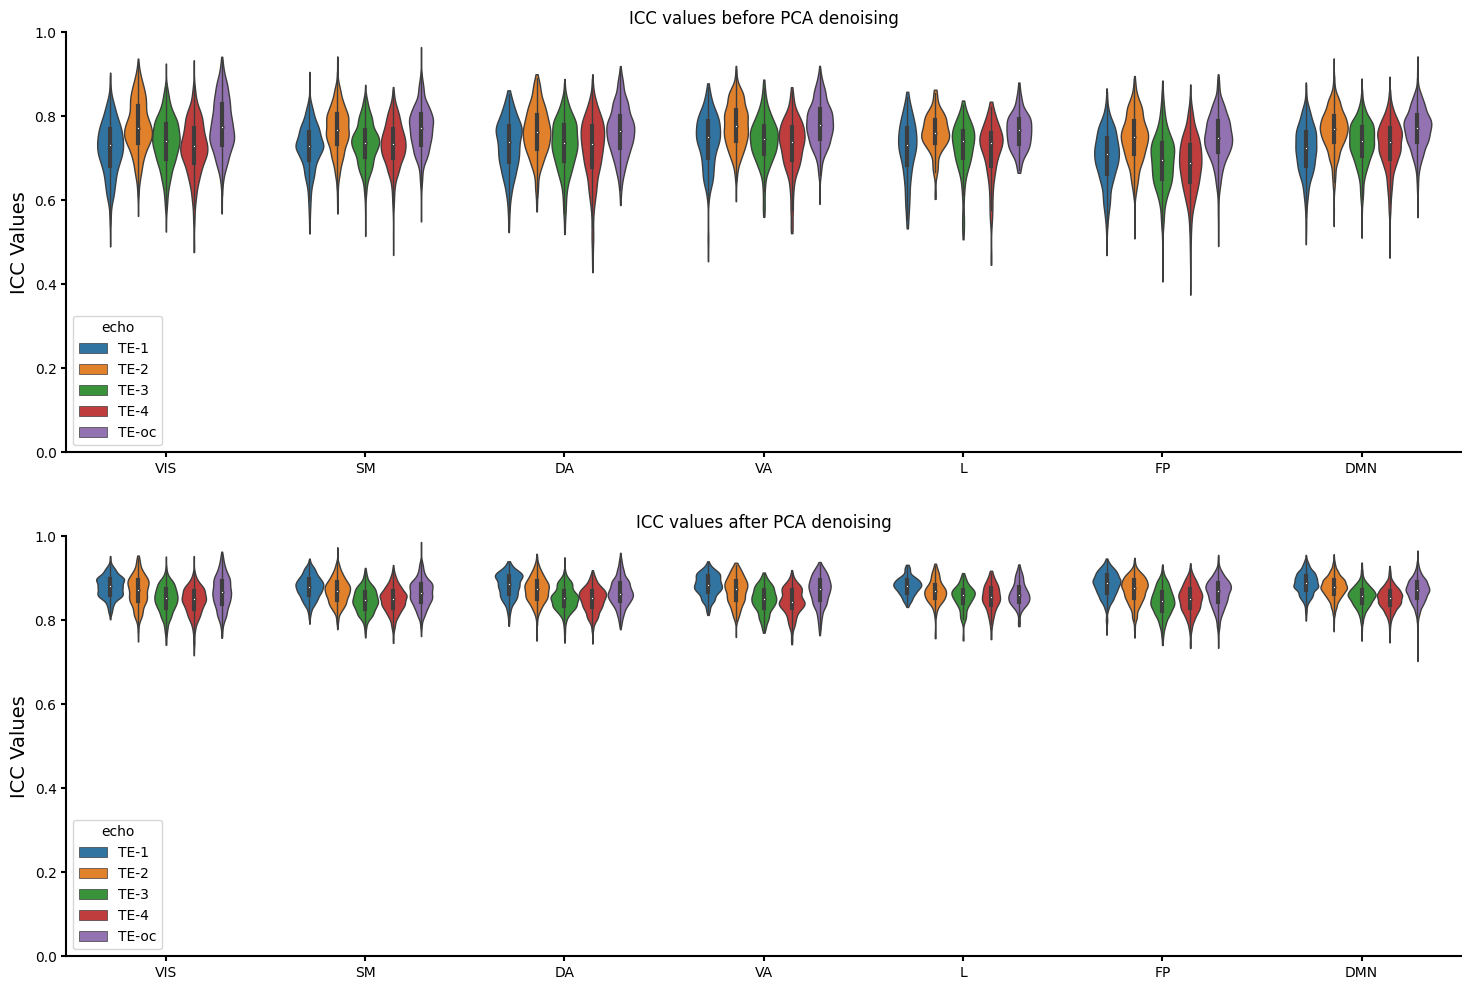

In [16]:
try:
    yeoOrder,limit_yeo=load_yeonets_matfile(filename="/media/miplab-nas2/Data3/Danyang/Multi-Echo-BOLD_fingerprinting/yeo_RS7_Schafer200S.mat")
except FileNotFoundError:
    yeoOrder,limit_yeo=load_yeonets_matfile(filename="E:\sp2\Multi-Echo-BOLD_fingerprinting\yeo_RS7_Schafer200S.mat")

fig = plt.figure(dpi=100, figsize=(18,12))
ax1 = plt.subplot(211)
plot_ICCs_violins(ICC_matrices, yeoOrder=yeoOrder,limit_yeo=limit_yeo, ax=ax1, title="ICC values before PCA denoising")

ax2 = plt.subplot(212)
plot_ICCs_violins(ICC_matrices_opt, yeoOrder=yeoOrder,limit_yeo=limit_yeo, ax=ax2, title="ICC values after PCA denoising")
     

In [17]:
N=200
yeo_all=loadmat('E:\sp2\Multi-Echo-BOLD_fingerprinting\yeo_RS7_Schafer{0}S.mat'.format(N))
nodeID_yeomap=np.array([i[0] for i in yeo_all['yeoROIs']])

node_strength=np.zeros(N)
for i in range(1,8):
    node_strength[np.array(nodeID_yeomap==i)[:N]]=(i)*10+np.random.normal(loc=0.0,scale=0.1,size=sum(np.array(nodeID_yeomap==i)[:N]))

cmap = plt.get_cmap('tab20')
new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=0, b=1),
        cmap(np.linspace(0, 0.35, 1000)))


In [18]:
ICC_vectors = np.sum(ICC_matrices, axis=1)[:,:200]
ICC_vectors_opt = np.sum(ICC_matrices_opt, axis=1)[:,:200]
# ICC_vectors

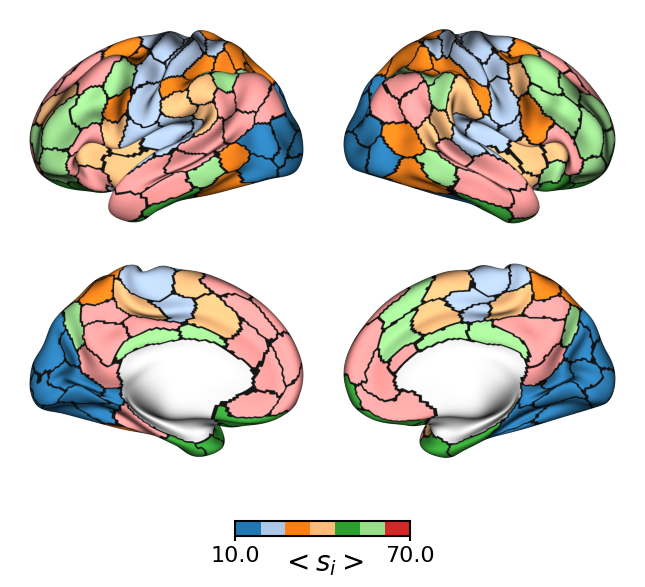

In [20]:
fig=normal_view(node_strength,edges=True,exp_form=False,q_thresh=0,cmap=new_cmap,parcellation=N,brightness=0.8,vmin=10,vmax=70)
fig


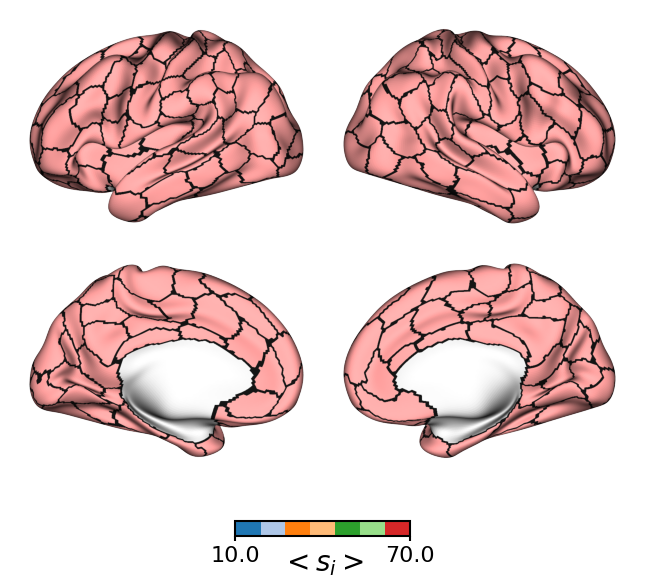

In [21]:
fig=normal_view(ICC_vectors[0],edges=True,exp_form=False,q_thresh=0,cmap=new_cmap,parcellation=N,brightness=0.8,vmin=10,vmax=70)
fig
